In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 8.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=cb2e23e811e823f1b37b9238e9f6a52712726af60b6d2f5fa61e86d3aec61e6c
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
# Import libraries

import numpy as np
import os
from keras.preprocessing import image
from keras import preprocessing
from keras.models import load_model

# Librerias para visualizar las imágenes
%matplotlib inline
import matplotlib.pyplot as plt

# Librerias para la explicabilidad del modelo
import lime
from lime import lime_image
from keras.applications.imagenet_utils import decode_predictions
from skimage.segmentation import mark_boundaries

# Librerias para Grad Cam
import cv2
from PIL import Image
import tensorflow as tf
import tensorflow.keras as K
from skimage.transform import resize
from tensorflow.keras.models import Model

In [ ]:
model_saved_dir = '/content/gdrive/MyDrive/tfm/models/resnet50/v2-03-ResNet50-model'

train_dir = '/content/gdrive/MyDrive/tfm/version2/train_dir/'
test_dir = '/content/gdrive/MyDrive/tfm/version2/test_dir/'
val_dir = '/content/gdrive/MyDrive/tfm/version2/val_dir/'

Mounted at /content/gdrive


In [ ]:
%%time

history_ft = load_model(model_saved_dir)

CPU times: user 20.6 s, sys: 2.12 s, total: 22.7 s
Wall time: 28.7 s


In [ ]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:

        loaded_image = preprocessing.image.load_img(
            path=img_path,
            target_size=(im_width,im_height,channels))

        img_array = preprocessing.image.img_to_array(loaded_image) / 255.

        img_np_array = np.expand_dims(img_array, axis = 0)
        
        out.append(img_np_array)
        #img = image.load_img(img_path, target_size=(299, 299))
        #x = image.img_to_array(img)
        #x = np.expand_dims(x, axis=0)
        #x = inc_net.preprocess_input(x)
        #out.append(x)
    return np.vstack(out)

In [ ]:
# https://keras.io/examples/vision/grad_cam/

def VizGradCAM(model, image, interpolant=0.5, plot_results=True):

    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """

    # Sanity Check
    assert (
        interpolant > 0 and interpolant < 1
    ), "Heatmap Interpolation Must Be Between 0 - 1"

    last_conv_layer = next(
        x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D)
    )
    target_layer = model.get_layer(last_conv_layer.name)

    original_img = image
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)

    # Obtain Prediction Index
    prediction_idx = np.argmax(prediction)

    # Compute Gradient of Top Predicted Class
    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        # Obtain the Prediction Loss
        loss = prediction[:, prediction_idx]

    # Gradient() computes the gradient using operations recorded
    # in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    # Obtain the Output from Shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    # Obtain Depthwise Mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    # Create a 7x7 Map for Aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    # Multiply Weights with Every Layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    # Resize to Size of Image
    activation_map = cv2.resize(
        activation_map.numpy(), (original_img.shape[1], original_img.shape[0])
    )

    # Ensure No Negative Numbers
    activation_map = np.maximum(activation_map, 0)

    # Convert Class Activation Map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (
        activation_map.max() - activation_map.min()
    )
    activation_map = np.uint8(255 * activation_map)

    # Convert to Heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    # Superimpose Heatmap on Image Data
    original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min())
        * 255
    )

    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Enlarge Plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(
            np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))
        )
    else:
        return cvt_heatmap

{'Apple___Apple_scab': '0.00%', 'Apple___Black_rot': '0.00%', 'Apple___Cedar_apple_rust': '0.00%', 'Apple___healthy': '0.00%', 'Blueberry___healthy': '0.00%', 'Cherry___healthy': '0.00%', 'Cherry___Powdery_mildew': '0.00%', 'Corn___Cercospora_leaf_spot Gray_leaf_spot': '0.00%', 'Corn___Common_rust': '0.00%', 'Corn___healthy': '0.00%', 'Corn___Northern_Leaf_Blight': '0.00%', 'Grape___Black_rot': '0.00%', 'Grape___Esca_(Black_Measles)': '0.00%', 'Grape___healthy': '99.71%', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': '0.00%', 'Orange___Haunglongbing_(Citrus_greening)': '0.00%', 'Peach___Bacterial_spot': '0.00%', 'Peach___healthy': '0.00%', 'Pepper,_bell___Bacterial_spot': '0.00%', 'Pepper,_bell___healthy': '0.00%', 'Potato___Early_blight': '0.01%', 'Potato___healthy': '0.00%', 'Potato___Late_blight': '0.00%', 'Raspberry___healthy': '0.00%', 'Soybean___healthy': '0.00%', 'Squash___Powdery_mildew': '0.00%', 'Strawberry___healthy': '0.00%', 'Strawberry___Leaf_scorch': '0.00%', 'Tomato___B

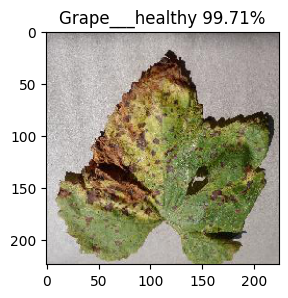

CPU times: user 250 ms, sys: 8.89 ms, total: 259 ms
Wall time: 1.56 s


<Figure size 600x400 with 0 Axes>

In [ ]:
%%time

im_width = 224
im_height = 224
channels=3

trained_classes_labels = os.listdir(train_dir)

#img_path = "/content/gdrive/MyDrive/tfm/version2/test_dir/Apple___Black_rot/image (1).JPG"
dir_path='/content/gdrive/MyDrive/tfm/version2/test_dir/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
name_image= 'image (10).JPG'
#name_image= 'image (10).jpg'

#img_path = "/content/gdrive/MyDrive/images-google/grape-4.jpg"

loaded_image = preprocessing.image.load_img(
        #path=img_path,
        path=os.path.join(dir_path,name_image),
        target_size=(im_width,im_height,channels))

img_array = preprocessing.image.img_to_array(loaded_image) / 255.

img_np_array = np.expand_dims(img_array, axis = 0)

predictions = history_ft.predict(img_np_array)
classidx = np.argmax(predictions[0])
label = trained_classes_labels[classidx]

predictions_pct = ["{:.2f}%".format(prob * 100) for prob in predictions[0] ]
print(dict(zip(trained_classes_labels, predictions_pct)), '\n' )
print("Prediction: %s (class %s) %s" % (label, classidx, predictions_pct[classidx])) 

plt.figure(figsize=(3,4))
plt.imshow(img_array)
plt.title("%s %s" % (label, predictions_pct[classidx]))
plt.show()

plt.gcf().clear()

In [ ]:
%%time

images = transform_img_fn([os.path.join(dir_path,name_image)])

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(images[0].astype('double'), history_ft.predict, top_labels=5, hide_color=0, num_samples=2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 28.2 s, sys: 763 ms, total: 29 s
Wall time: 29.1 s


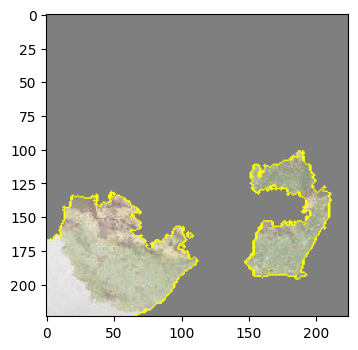

In [ ]:
# We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

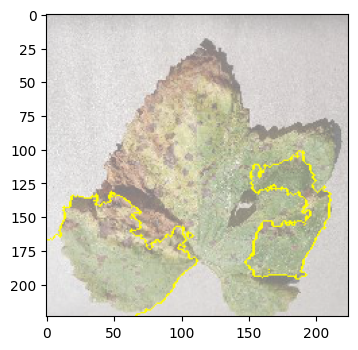

In [ ]:
# Or with the rest of the image present:

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

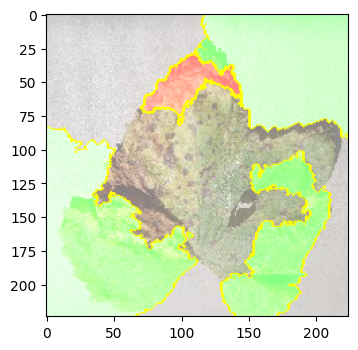

In [ ]:
# We can also see the 'pros and cons' (pros in green, cons in red)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

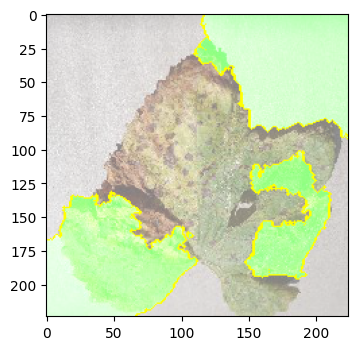

In [ ]:
# Or the pros and cons that have weight at least 0.1

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

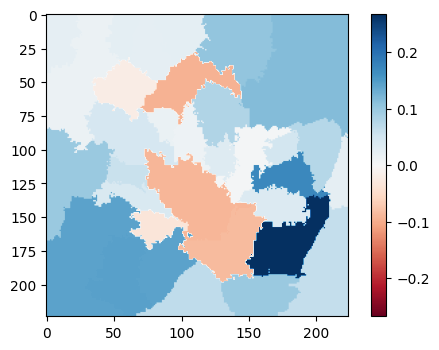

In [ ]:
# Alternatively, we can also plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.

#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

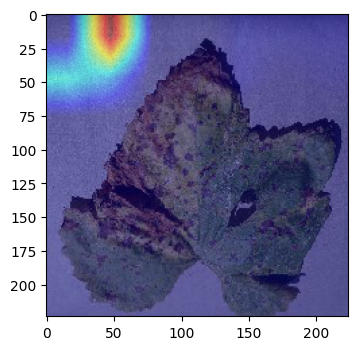

In [ ]:
VizGradCAM(history_ft, img_array)